# RandomForest, LogisticRegression ensemble

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

In [3]:
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


## Data Processing

- PassengerId	- 승객 고유 ID
- HomePlanet - 출발한 행성=거주행성
- CryoSleep - 수면 상태 선택
- Cabin - deck/num/side
- Destination - 도착지
- Age - 나이
- VIP - VIP 서비스 여부
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 각 서비스에 대해 지불한 비용
- Name - 이름
- Transported - 예측할 컬럼

In [4]:
# 필요없는 컬럼 삭제
train_df.drop(['PassengerId', 'Name'], axis=1, inplace=True)
test_df.drop(['PassengerId', 'Name'], axis=1, inplace=True)

In [5]:
train_df.isnull().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [6]:
# 수치형 데이터 결측치 중간 값 보간
train_df.interpolate(method='linear', limit_direction='forward', inplace=True)
test_df.interpolate(method='linear', limit_direction='forward', inplace=True)

# 범주형 데이터 결측치 이전 값 보간
train_df.fillna(method='pad', inplace=True)
test_df.fillna(method='pad', inplace=True)

In [7]:
train_df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


In [8]:
# 범주형 -> 수치형 HomePlanet
# Earth : 0, Europa : 2177, Mars : 1796

# 매핑 딕셔너리
mapping = {'Earth': 0, 'Europa': 1, 'Mars': 2}

# 매핑 함수 정의
def map_function(x):
    return mapping[x]

# 매핑 적용
train_df['HomePlanet'] = list(map(map_function, train_df['HomePlanet']))
test_df['HomePlanet'] = list(map(map_function, test_df['HomePlanet']))

In [9]:
# 범주형 -> 수치형 CryoSleep
# False : 0, True = 1
train_df['CryoSleep'] = train_df['CryoSleep'].apply(lambda x: 0 if x == False else 1)
test_df['CryoSleep'] = test_df['CryoSleep'].apply(lambda x: 0 if x == False else 1)

In [10]:
# 범주형 -> 수치형 VIP
# False : 0, True = 1
train_df['VIP'] = train_df['VIP'].apply(lambda x: 0 if x == False else 1)
test_df['VIP'] = test_df['VIP'].apply(lambda x: 0 if x == False else 1)

In [11]:
# 범주형 -> 수치형 Destination
# TRAPPIST-1e : 0, 55 Cancri e : 2177, PSO J318.5-22 : 1796

# 매핑 딕셔너리
mapping = {'TRAPPIST-1e': 0, '55 Cancri e': 1, 'PSO J318.5-22': 2}

# 매핑 함수 정의
def map_function(x):
    return mapping[x]

# 매핑 적용
train_df['Destination'] = list(map(map_function, train_df['Destination']))
test_df['Destination'] = list(map(map_function, test_df['Destination']))

In [12]:
# Cabin - deck,num,side 에서 deck만 살리기
for i in range(len(train_df)):
    train_df.iloc[i, 2] = train_df.iloc[i, 2][0]
    
for i in range(len(test_df)):
    test_df.iloc[i, 2] = train_df.iloc[i, 2][0]

In [13]:
# 범주형 -> 수치형 Cabin
# Earth : 0, Europa : 2177, Mars : 1796

# 매핑 딕셔너리
mapping = {'F': 0, 'G': 1, 'E': 2,'B': 3, 'C': 4, 'D': 5,'A': 6, 'T': 7}

# 매핑 함수 정의
def map_function(x):
    return mapping[x]

# 매핑 적용
train_df['Cabin'] = list(map(map_function, train_df['Cabin']))
test_df['Cabin'] = list(map(map_function, test_df['Cabin']))

In [14]:
train_df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,3,0,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,0,0,0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,1,0,6,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,1,0,6,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,0,0,0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,6,1,41.0,1,0.0,6819.0,0.0,1643.0,74.0,False
8689,0,1,1,2,18.0,0,0.0,0.0,0.0,0.0,0.0,False
8690,0,0,1,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,True
8691,1,0,2,1,32.0,0,0.0,1049.0,0.0,353.0,3235.0,False


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

In [16]:
X = train_df.iloc[:, :11]
y = train_df['Transported']

In [17]:
model.fit(X, y)

RandomForestClassifier()

feature ranking~~
1. feature Age (0.154)
2. feature Spa (0.134)
3. feature RoomService (0.126)
4. feature VRDeck (0.121)
5. feature CryoSleep (0.116)
6. feature FoodCourt (0.110)
7. feature ShoppingMall (0.102)
8. feature Cabin (0.064)
9. feature HomePlanet (0.046)
10. feature Destination (0.024)
11. feature VIP (0.003)


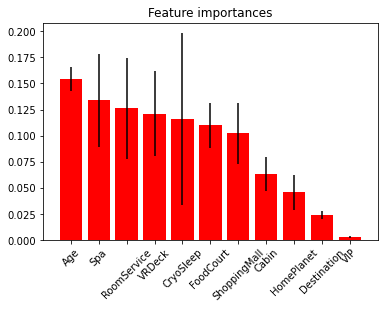

In [18]:
import matplotlib.pyplot as plt
import numpy as np
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

print("feature ranking~~")

for f in range(X.shape[1]):
    print("{}. feature {} ({:.3f})" .format(f+1, X.columns[indices][f], importances[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

### 위 시각화를 통해 VIP와 Destination 변수 제거하기

In [19]:
train_df.drop(['Destination', 'VIP'], axis=1, inplace=True)
test_df.drop(['Destination', 'VIP'], axis=1, inplace=True)

In [20]:
train_df

,HomePlanet,CryoSleep,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,3,39.0,0.0,0.0,0.0,0.0,0.0,False
1,0,0,0,24.0,109.0,9.0,25.0,549.0,44.0,True
2,1,0,6,58.0,43.0,3576.0,0.0,6715.0,49.0,False
3,1,0,6,33.0,0.0,1283.0,371.0,3329.0,193.0,False
4,0,0,0,16.0,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...
8688,1,0,6,41.0,0.0,6819.0,0.0,1643.0,74.0,False
8689,0,1,1,18.0,0.0,0.0,0.0,0.0,0.0,False
8690,0,0,1,26.0,0.0,0.0,1872.0,1.0,0.0,True
8691,1,0,2,32.0,0.0,1049.0,0.0,353.0,3235.0,False


# Training

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
class EnsembleModel:
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
    
    def predict(self, X):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(X))
        return np.round(np.mean(predictions, axis=0)).astype(int)

In [28]:
new_X = train_df.iloc[:, :9]
new_y = train_df['Transported']

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

In [30]:
model = RandomForestClassifier()

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

In [33]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()

In [34]:
ensemble = EnsembleModel(models=[grid_rf, LR_model])

ensemble.fit(new_X, new_y)

C:\Users\SJ\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
X_test = test_df

y_pred = ensemble.predict(X_test)

In [37]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [36]:
submission_df = pd.read_csv("./dataset/sample_submission.csv")
submission_df['Transported'] = y_pred
submission_df.to_csv("submission5.csv", index=False)